In [1]:
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy import stats

runlist=[1414, 1415, 1417, 1418] # Select runs with bias scans
bias = np.array([0, 1, -0.5, 0.5])

In [2]:
processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist, userunlist=True, remove=False)
arr, arSpills = processor.getData(DATASET) # get akward array for "run" tree

In [30]:
list_febID = arr['febID'].to_list()
FEBID = min(list_febID, key=lambda x: len(x))

NFEBS=len(FEBID)
print("Dataset: %s"%DATASET)
print("Number of FEBs: %d"%NFEBS)
print("List of FEBs: %s"%FEBID)

Dataset: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.root
Number of FEBs: 6
List of FEBs: [22, 25, 17, 14, 20, 1]


In [31]:
if not np.array_equal(np.array(runlist), arr['runNumber'].to_numpy()):
    print("Input run list order and data do not match")

In [32]:
#Mask channels which were not calibrated
useRaw = False
var='calibConstantsTemperatureCorrected'
if useRaw:
    var = 'calibConstants'
    
arSPE = ak.mask(arr[var], arr[var]>0).to_numpy()

Bad channel: 0, 33


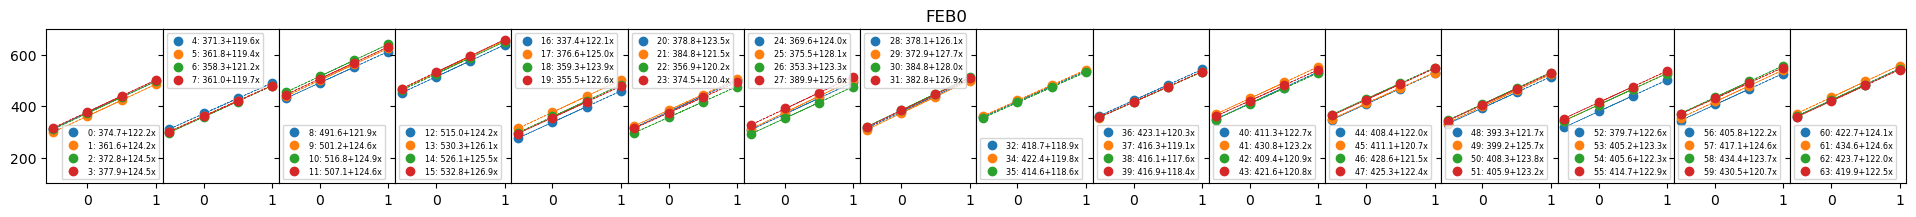

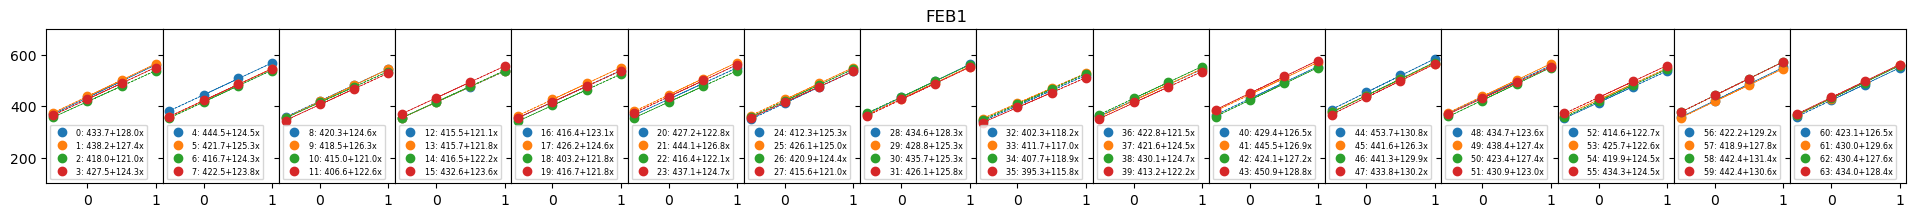

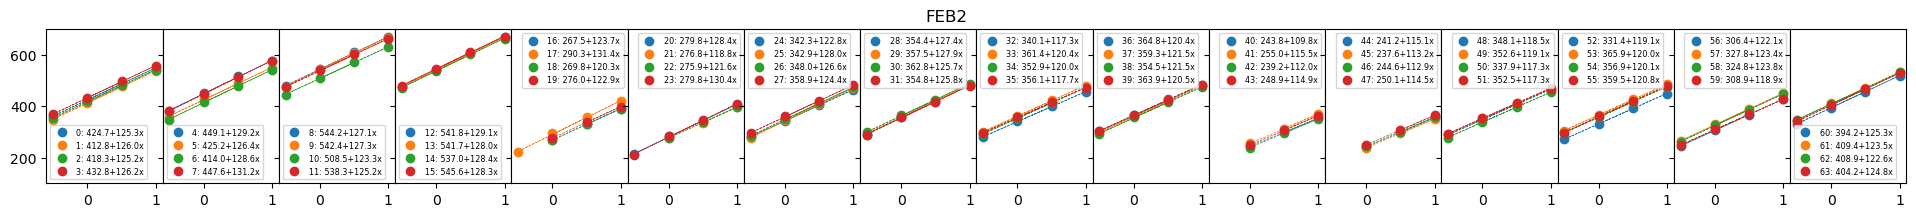

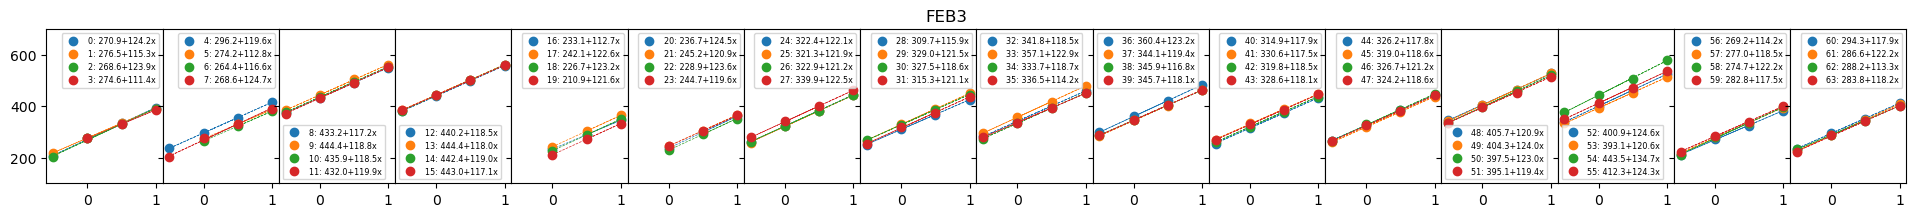

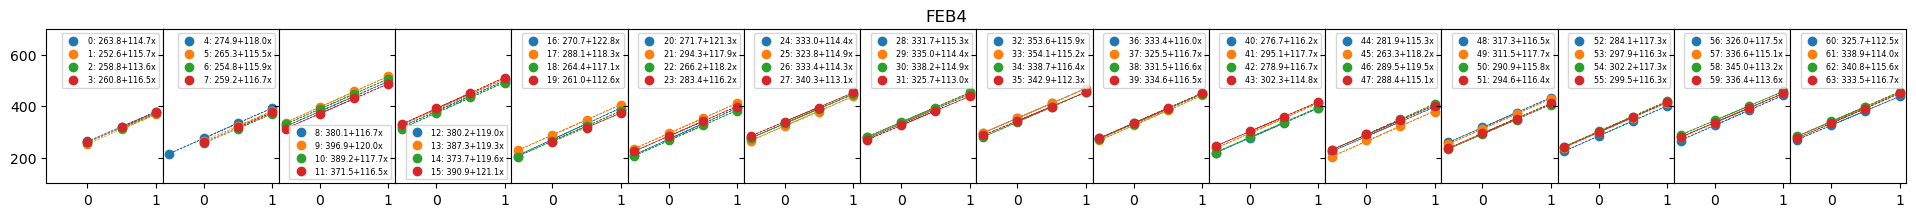

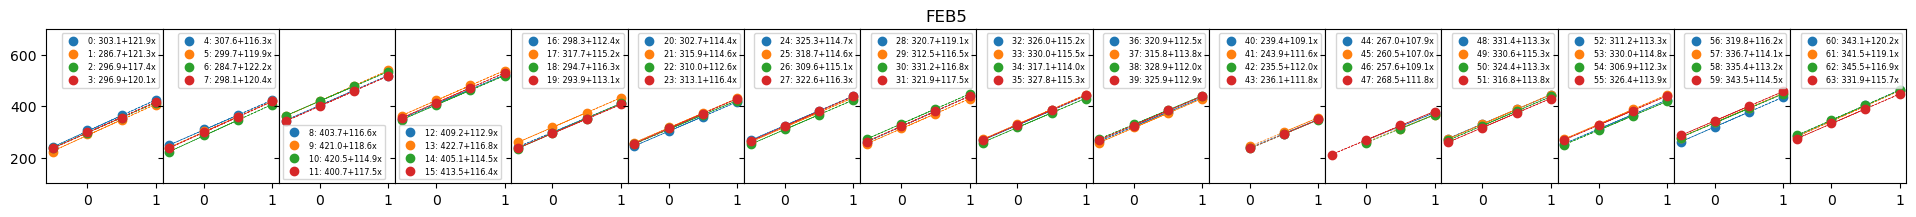

In [34]:
goal_overV = 3
df = pd.DataFrame(columns=['feb', 'chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err', "overV", "offsetV"])
for feb in range(NFEBS):
    
    fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(24, 2), sharey=True)
    plt.suptitle("FEB%d" % feb)
    plt.subplots_adjust(wspace=0)

    for chan in range(64):
        x=bias
        y=arSPE[:, feb, chan]
        mask = ~np.isnan(y)
        x=x[mask]
        y=y[mask]

        if y.size==0:
            print("Bad channel: %d, %d"%(feb,chan))
            continue
            
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        ratio = intercept / slope
        ratio_stderr = ratio * np.sqrt((std_err / slope)**2)
                        
        new_row = {'feb': feb, 'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': ratio_stderr,
                   'overV': ratio, 'offsetV': ratio-goal_overV}
        df.loc[len(df)] = new_row
            
        ax = axs[chan//4]
        markers = ax.plot(x, y, 'o', label='%d: %.1f+%.1fx'%(chan, intercept, slope))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.5)
        ax.set_ylim(100, 700)
        ax.set_xlim(-0.6, 1.1)
        ax.legend(fontsize='xx-small')
        

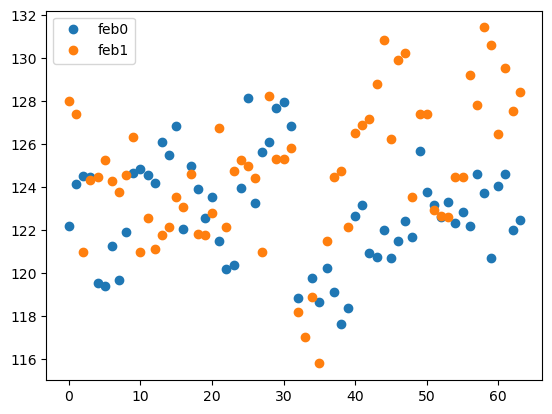

In [42]:
plt.plot(df.query('feb==0')['chan'], df.query('feb==0')['slope'], 'o', label='feb0')
plt.plot(df.query('feb==1')['chan'], df.query('feb==1')['slope'], 'o', label='feb1')
plt.legend();

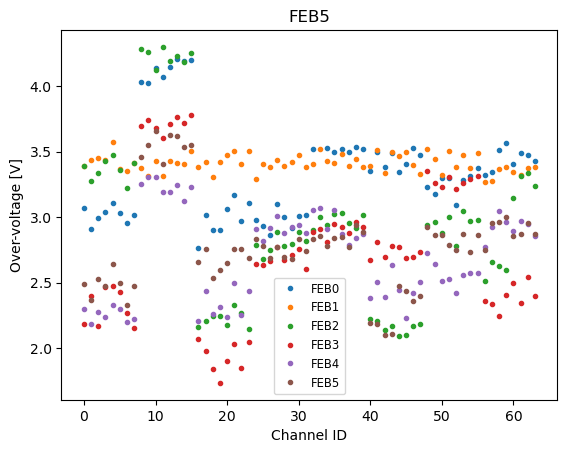

In [63]:
for feb in range(NFEBS):
    plt.title("FEB%d"%feb)
    plt.plot(df.query("feb==%d"%feb)['chan'], df.query("feb==%d"%feb)['overV'], '.', label="FEB%d"%feb)
    plt.xlabel("Channel ID")
    plt.ylabel("Over-voltage [V]")
    plt.legend(fontsize='small')

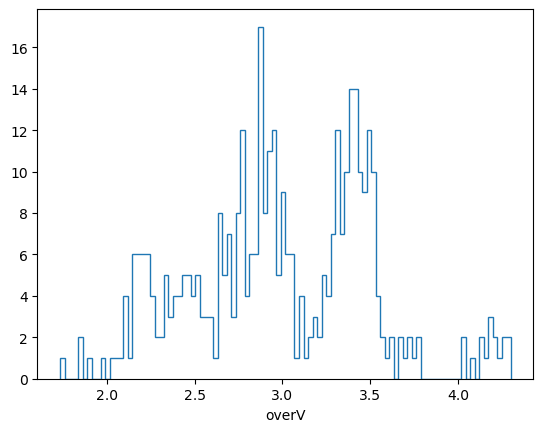

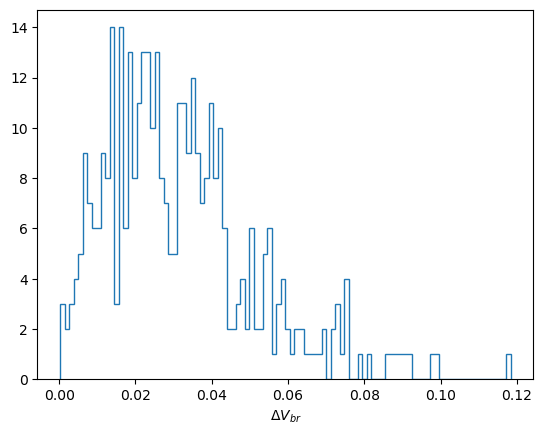

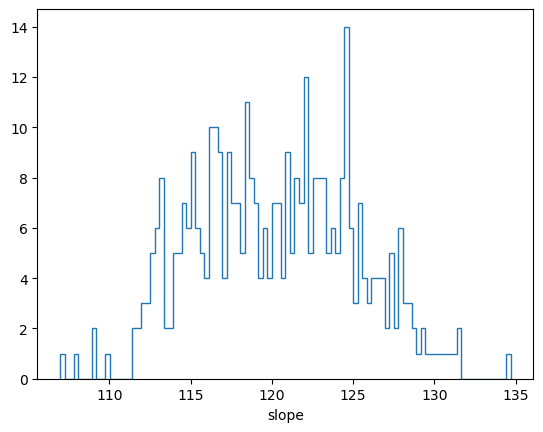

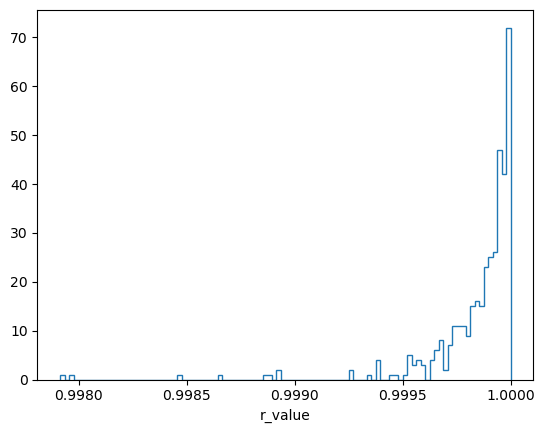

In [13]:
plt.hist(df['overV'], bins=100, histtype='step');
plt.xlabel('overV');

plt.figure()
plt.hist(df['std_err'], bins=100, histtype='step');
plt.xlabel('std_err');
plt.xlabel('$\Delta V_{br}$')

plt.figure()
plt.hist(df['slope'], bins=100, histtype='step');
plt.xlabel('slope');

plt.figure()
plt.hist(df['r_value'], bins=100, histtype='step');
plt.xlabel('r_value');

In [9]:
pd.set_option('display.max_rows', None)
df[['feb', 'chan', 'slope', 'overV', 'offsetV', 'std_err']]

,feb,chan,slope,overV,offsetV,std_err
0,0,0,122.176208,3.066797,0.066797,0.025764
1,0,1,124.167804,2.911788,-0.088212,0.019059
2,0,2,124.536011,2.993833,-0.006167,0.023967
3,0,3,124.474591,3.036335,0.036335,0.033288
4,0,4,119.562000,3.105385,0.105385,0.025396
5,0,5,119.393396,3.030485,0.030485,0.025862
6,0,6,121.245605,2.955432,-0.044568,0.016566
7,0,7,119.708990,3.015450,0.015450,0.012182
8,0,8,121.899982,4.032540,1.032540,0.012969
9,0,9,124.641406,4.020786,1.020786,0.004891
